<div style="float:left">
    <h1 style="width:450px">CASA 0013</h1>
    <h2 style="width:700px">Introduction to Programming for Spatial Analysts (20/21)</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>
<div style="float:left">
    <h4 style="width:700px">Title: Based on regression analysis to make recommendations for Airbnb's investment location and business direction</h4>
    <h4 style="width:450px"> Student id: 20180197</h4>
</div>
<div style="float:right">
    <h5 style="width:350px">Word count for the Executive Briefing: 1222 words</h5>
    <h5 style="width:200px">(with 5 figures.)</h5>

## Executive Summary

Airbnb was founded in 2008. As a representative of the "sharing economy", Airbnb has expanded rapidly and now operates in hundreds of cities around the world. In the post-economic crisis era, Airbnb is gradually eroding the traditional short-term rental market and becoming a new financial asset. Therefore, now is the best time to invest in Airbnb.

This report will state in: 1) the advantages of Airbnb compared to traditional short-term rentals, and point out the feasibility and importance of Airbnb's investment; 2) use regression analysis to guide Airbnb's investment in terms of spatial investment location and housing investment; 3) point out Investors need to pay attention to issues when operating Airbnb houses.

The _key findings_ of this report are as follows:

1. There are currently __three Airbnb clusters__ in London, mainly __located on the north side of the Thames__. In addition, there is __a gestational cluster in the southern area__.

2. The distribution pattern of the number of Airbnb on LSOA __overlaps with the distribution of tourist attractions. __

3. __Daily spaces__ such as parks and public transportation __show the difference between the centre and the periphery.__

4. __In the central area of London__, we need to pay more attention to the __housing capacity__. __In the south side of the Thames__, we need to pay more attention to __the number of bedrooms__.

___

## Reproducible Analysis

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

In [4]:
#Load data
commercial = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/commercial.geojson?raw=true').to_crs('epsg:27700')
historic = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/historic.geojson?raw=true').to_crs('epsg:27700')
park = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/park.geojson?raw=true').to_crs('epsg:27700')
station = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/pub_trans.geojson?raw=true').to_crs('epsg:27700')
tourism = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/tourism.geojson?raw=true').to_crs('epsg:27700')
university = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/university.geojson?raw=true').to_crs('epsg:27700')

In [5]:
boros = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/Boroughs.gpkg?raw=true')

<AxesSubplot:>

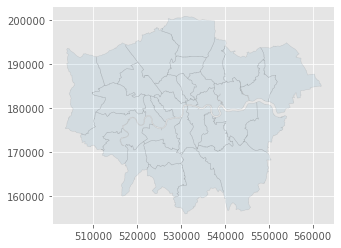

In [6]:
boros.plot(facecolor=None,edgecolor='black',alpha=.1)

<AxesSubplot:>

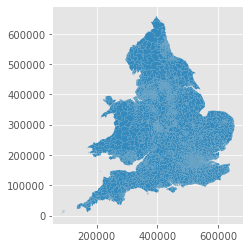

In [7]:
msoas = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
msoas.plot()

<AxesSubplot:>

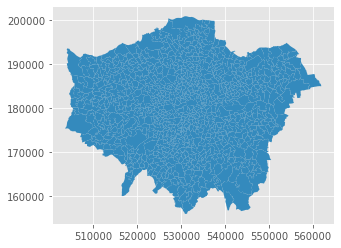

In [8]:
lsoas = gpd.read_file('https://github.com/HaochengSun722/i2p_data/blob/main/18_lsoa.json?raw=true').to_crs('epsg:27700')
lsoas.plot()

In [9]:
url = 'https://github.com/HaochengSun722/assignment/blob/main/listings.csv.gz?raw=true'
df = pd.read_csv(url, compression='gzip', low_memory=False, 
                 usecols=['longitude','latitude','price',"host_id"])
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 77,136 x 4


In [10]:
df.price=df.price.str.replace(',','')
df['price'] = df.price.str.replace('$','').astype('float')

In [11]:
df.price.describe()

count                                77,136.0000
mean                                    120.5698
std                                     412.5395
min                                       0.0000
25%                                      44.0000
50%                                      75.0000
75%                                     127.0000
max                                  18,175.0000
Name: price, dtype: float64

In [12]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

Text(0.5, 1.0, 'PCA Component 1')

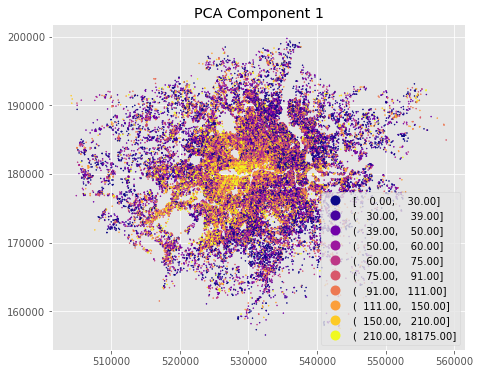

In [13]:
ax=gdf.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6),legend=True);
ax.set_title(f'PCA Component 1')

In [14]:
df2 = df.loc[:,['longitude','latitude']]

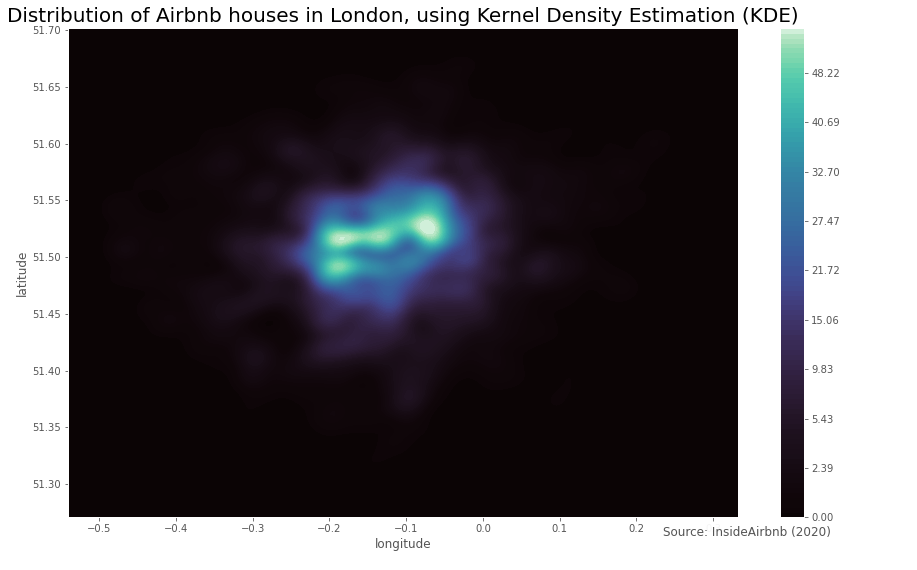

In [15]:
f,ax = plt.subplots(figsize=(15,9))
sns.kdeplot(
    data=df, x='longitude', y='latitude',
    fill=True, thresh=0, levels=100, cmap="mako",ax=ax,shade=True,cbar=True
)
#boros.plot(facecolor='none',edgecolor='white',alpha=.5, ax=ax)
#ax.axis('off')
ax.set_title('Distribution of Airbnb houses in London, using Kernel Density Estimation (KDE)', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))


In [16]:
f.savefig('KDE.jpg', dpi=300)

In [17]:
#######data clean

In [18]:
lsoas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   msoa_code     983 non-null    object  
 1   msoa_name     983 non-null    object  
 2   la_code       983 non-null    object  
 3   la_name       983 non-null    object  
 4   geoeast       983 non-null    int64   
 5   geonorth      983 non-null    int64   
 6   popeast       983 non-null    int64   
 7   popnorth      983 non-null    int64   
 8   area_km2      983 non-null    float64 
 9   MOVEMENT_ID   983 non-null    object  
 10  DISPLAY_NAME  983 non-null    object  
 11  geometry      983 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(6)
memory usage: 92.3+ KB


In [19]:
ml = gpd.sjoin(gdf, lsoas, how='right')

In [20]:
mlgp_mean = ml.groupby('msoa_code')['price'].agg('mean').reset_index() # msoa listings grouped price

In [21]:
mlgp_mean[mlgp_mean.price.isna()]=0

In [22]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77136 entries, 0 to 77135
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   host_id    77136 non-null  int64   
 1   latitude   77136 non-null  float64 
 2   longitude  77136 non-null  float64 
 3   price      77136 non-null  float64 
 4   geometry   77136 non-null  geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 2.9 MB


In [23]:
mlgc0 = ml.groupby(['msoa_code'])['host_id'].agg(airbnb_Count='count').reset_index() 

In [24]:
ml_commercial = gpd.sjoin(commercial, lsoas, how='right')
mlgc1 = ml_commercial.groupby(['msoa_code'])['osm_id'].agg(commercial_Count='count').reset_index() 

In [25]:
ml_historic = gpd.sjoin(historic,lsoas, how='right')
mlgc2 = ml_historic.groupby(['msoa_code'])['osm_id'].agg(historic_Count='count').reset_index()

In [26]:
ml_park = gpd.sjoin(park, lsoas, how='right')
mlgc3 = ml_park.groupby(['msoa_code'])['osm_id'].agg(park_Count='count').reset_index()

In [27]:
ml_station = gpd.sjoin(station, lsoas, how='right')
mlgc4 = ml_station.groupby(['msoa_code'])['osm_id'].agg(station_Count='count').reset_index() 

In [28]:
ml_tourism = gpd.sjoin(tourism, lsoas, how='right')
mlgc5 = ml_tourism.groupby(['msoa_code'])['osm_id'].agg(tourism_Count='count').reset_index() 

In [29]:
ml_university = gpd.sjoin(university, lsoas, how='right')
mlgc6 = ml_university.groupby(['msoa_code'])['osm_id'].agg(university_Count='count').reset_index() 

In [30]:
new_df1 = pd.merge(mlgc0, mlgc1, on='msoa_code')
new_df2 = pd.merge(new_df1, mlgc2, on='msoa_code')
new_df3 = pd.merge(new_df2, mlgc3, on='msoa_code')
new_df4 = pd.merge(new_df3, mlgc4, on='msoa_code')
new_df5 = pd.merge(new_df4, mlgc5, on='msoa_code')
new_df6 = pd.merge(new_df5, mlgc6, on='msoa_code')

In [31]:
new_df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   msoa_code         983 non-null    object
 1   airbnb_Count      983 non-null    int64 
 2   commercial_Count  983 non-null    int64 
 3   historic_Count    983 non-null    int64 
 4   park_Count        983 non-null    int64 
 5   station_Count     983 non-null    int64 
 6   tourism_Count     983 non-null    int64 
 7   university_Count  983 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 69.1+ KB


In [32]:
Plot_final=pd.merge(new_df6, lsoas,on='msoa_code')

In [33]:
GEO_final = gpd.GeoDataFrame(Plot_final)

In [34]:
GEO_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   msoa_code         983 non-null    object  
 1   airbnb_Count      983 non-null    int64   
 2   commercial_Count  983 non-null    int64   
 3   historic_Count    983 non-null    int64   
 4   park_Count        983 non-null    int64   
 5   station_Count     983 non-null    int64   
 6   tourism_Count     983 non-null    int64   
 7   university_Count  983 non-null    int64   
 8   msoa_name         983 non-null    object  
 9   la_code           983 non-null    object  
 10  la_name           983 non-null    object  
 11  geoeast           983 non-null    int64   
 12  geonorth          983 non-null    int64   
 13  popeast           983 non-null    int64   
 14  popnorth          983 non-null    int64   
 15  area_km2          983 non-null    float64 
 16  MOVEMENT_ID       

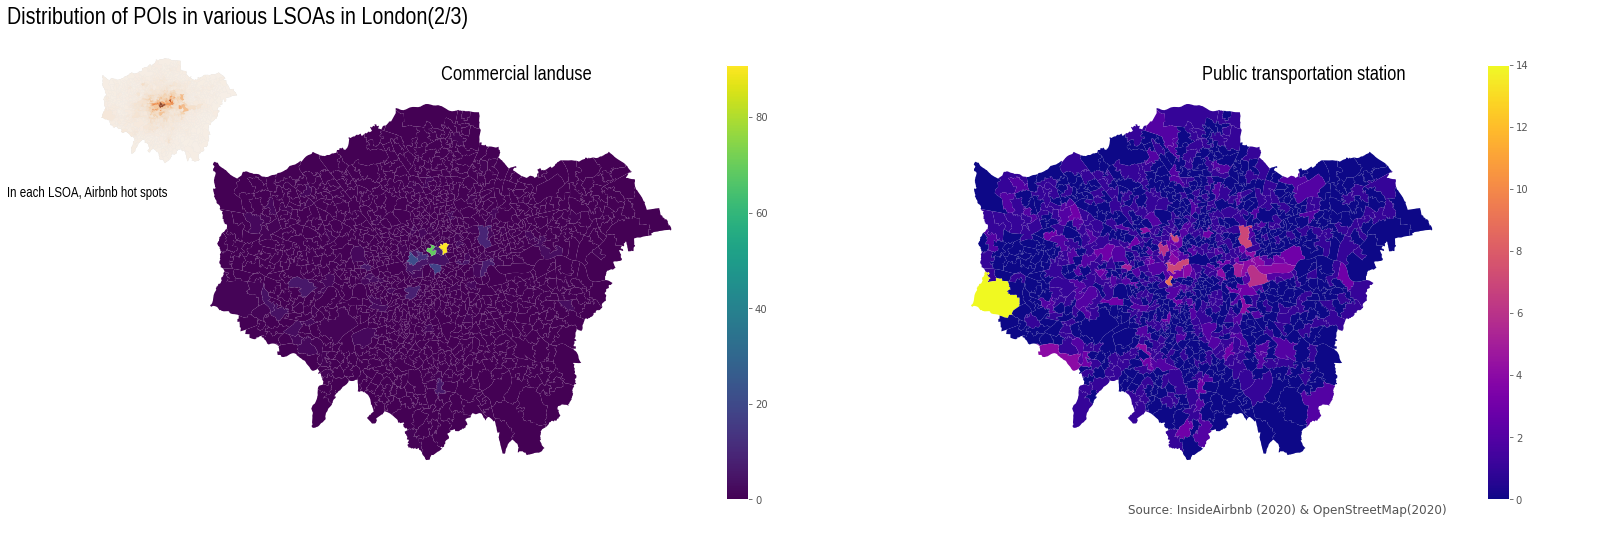

In [35]:
f,axes = plt.subplots(1,2,figsize=(25,8))

GEO_final.plot(column='commercial_Count', ax=axes[0], legend=True, cmap='viridis')
GEO_final.copy().plot(column='station_Count', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
lsoas.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
GEO_final.plot(column='airbnb_Count', alpha=.8,cmap='Oranges', ax=ax2)
ax2.axis('off')

f.suptitle('Distribution of POIs in various LSOAs in London(2/3)', x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Commercial landuse', size=20, **tfont)
axes[1].set_title('Public transportation station', size=20, **tfont)

a = ax.annotate('Source: InsideAirbnb (2020) & OpenStreetMap(2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555') 

plt.figtext(x=0.025, y=0.65, s='In each LSOA, Airbnb hot spots', size=14, **tfont);


In [36]:
f.savefig('poi distribution2.jpg', dpi=300)

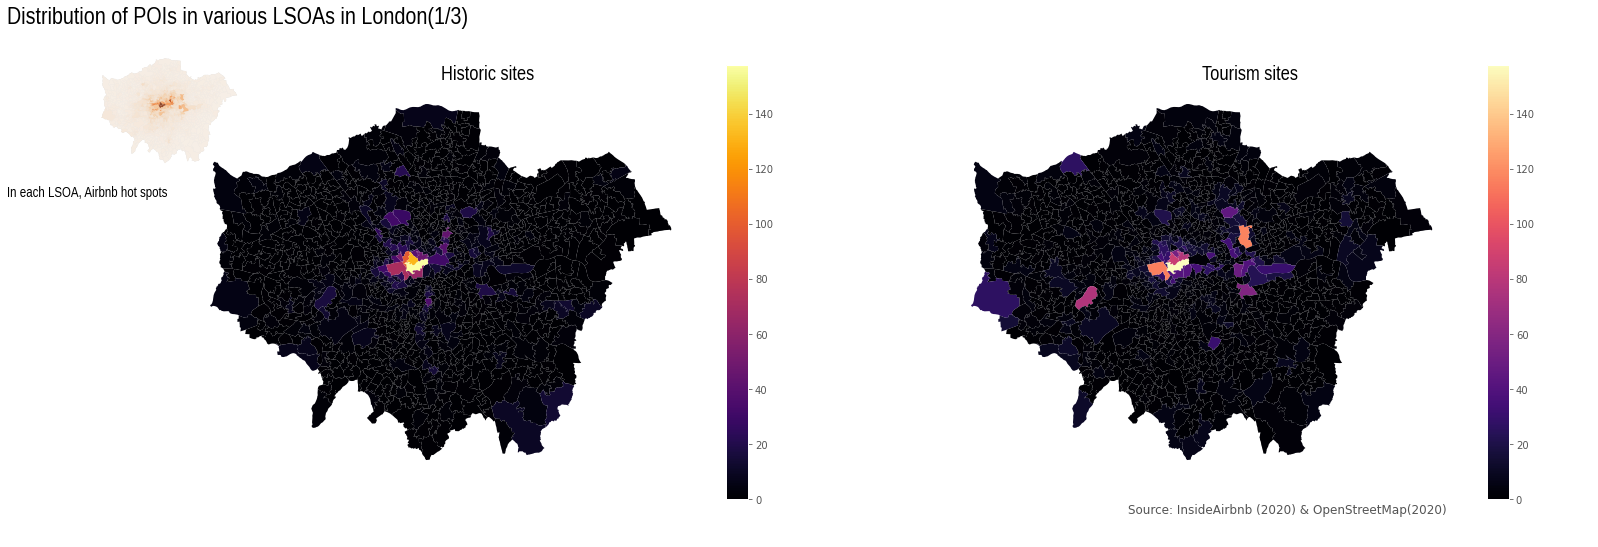

In [37]:
f,axes = plt.subplots(1,2,figsize=(25,8))

GEO_final.plot(column='historic_Count', ax=axes[0], legend=True, cmap='inferno')
GEO_final.copy().plot(column='tourism_Count', ax=axes[1], legend=True, cmap='magma')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
lsoas.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
GEO_final.plot(column='airbnb_Count', alpha=.8,cmap='Oranges', ax=ax2)
ax2.axis('off')

f.suptitle('Distribution of POIs in various LSOAs in London(1/3)', x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Historic sites', size=20, **tfont)
axes[1].set_title('Tourism sites', size=20, **tfont)

a = ax.annotate('Source: InsideAirbnb (2020) & OpenStreetMap(2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555') 
plt.figtext(x=0.025, y=0.65, s='In each LSOA, Airbnb hot spots', size=14, **tfont);


In [38]:
f.savefig('poi distribution1.jpg', dpi=300)

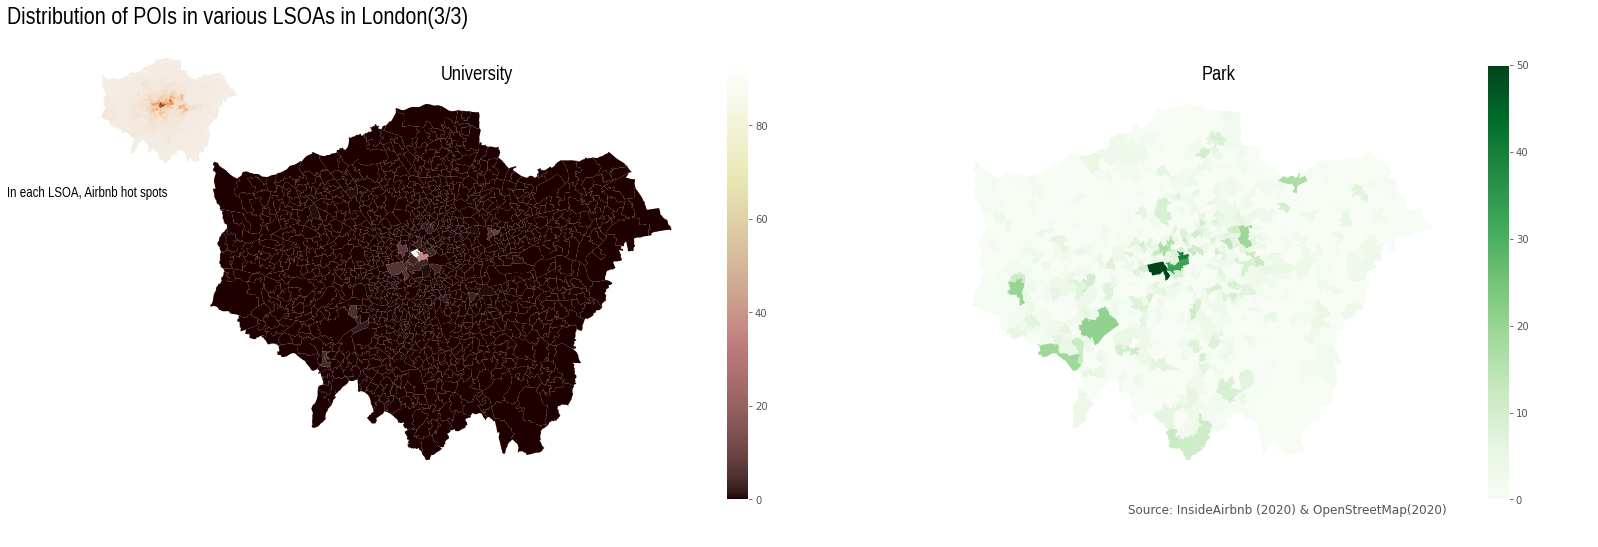

In [39]:
f,axes = plt.subplots(1,2,figsize=(25,8))

GEO_final.plot(column='university_Count', ax=axes[0], legend=True, cmap='pink')
GEO_final.copy().plot(column='park_Count', ax=axes[1], legend=True, cmap='Greens')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
lsoas.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
GEO_final.plot(column='airbnb_Count', alpha=.8,cmap='Oranges', ax=ax2)
ax2.axis('off')

f.suptitle('Distribution of POIs in various LSOAs in London(3/3)', x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('University', size=20, **tfont)
axes[1].set_title('Park', size=20, **tfont)

a = ax.annotate('Source: InsideAirbnb (2020) & OpenStreetMap(2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')

plt.figtext(x=0.025, y=0.65, s='In each LSOA, Airbnb hot spots', size=14, **tfont);


In [40]:
f.savefig('poi distribution3.jpg', dpi=300)

In [41]:
###OLS

In [42]:
ols=new_df6.drop(['msoa_code'],axis=1)

In [43]:
ols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   airbnb_Count      983 non-null    int64
 1   commercial_Count  983 non-null    int64
 2   historic_Count    983 non-null    int64
 3   park_Count        983 non-null    int64
 4   station_Count     983 non-null    int64
 5   tourism_Count     983 non-null    int64
 6   university_Count  983 non-null    int64
dtypes: int64(7)
memory usage: 61.4 KB


In [44]:
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [45]:
df_predictors_selected_VIF = drop_column_using_vif_(ols.drop('airbnb_Count', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['commercial_Count', 'historic_Count', 'park_Count', 'station_Count',
       'tourism_Count', 'university_Count'],
      dtype='object')


In [46]:
model_Airbnb = sm.OLS(endog=ols[['airbnb_Count']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_Airbnb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           airbnb_Count   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     133.3
Date:                Wed, 13 Jan 2021   Prob (F-statistic):          3.58e-123
Time:                        17:32:03   Log-Likelihood:                -5670.8
No. Observations:                 983   AIC:                         1.136e+04
Df Residuals:                     976   BIC:                         1.139e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               50.1040      3.074     16.301      0.000      44.072      56.136
commercial_Count     5.5509      0.667      8.326      0.000       4.243       6.859
historic_Count       4.4910      0.374     12.008      0.000       3.757       5.225
park_Count           0.1588      0.816      0.194      0.846      -1.443       1.761
station_Count        9.3656      2.554      3.667      0.000       4.354      14.378
tourism_Count        1.7897      0.388      4.608      0.000       1.028       2.552
university_Count     0.1078      0.806      0.134      0.894      -1.474       1.689
==============================================================================
Omnibus:                      464.532   Durbin-Watson:                   0.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3035.693
Skew:                           2.078   Prob(JB):                         0.00
Kurtosis:                      10.539   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

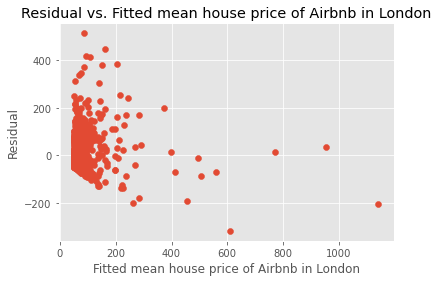

In [47]:
plt.scatter(model_Airbnb.fittedvalues, model_Airbnb.resid)
# adding title and labels
plt.xlabel('Fitted mean house price of Airbnb in London')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted mean house price of Airbnb in London')
plt.show()

In [48]:
#######GWR2

In [49]:
url = 'https://github.com/HaochengSun722/assignment/blob/main/listings.csv.gz?raw=true'
df2 = pd.read_csv(url, compression='gzip', low_memory=False, 
                 usecols=['longitude','latitude','price','accommodates','bedrooms','review_scores_rating','reviews_per_month'])

In [50]:
df2.price=df2.price.str.replace(',','')
df2['price'] = df2.price.str.replace('$','').astype('float')

In [51]:
df2.drop(df2.bedrooms[df2.bedrooms.isna()].index.values,axis=0,inplace=True)
print(f"df2 now contains {df2.shape[0]} rows.")

df2 now contains 72284 rows.


In [52]:
df2.drop(df2.accommodates[df2.accommodates.isna()].index.values,axis=0,inplace=True)
print(f"df2 now contains {df2.shape[0]} rows.")
df2.drop(df2.review_scores_rating[df2.review_scores_rating.isna()].index.values,axis=0,inplace=True)
print(f"df2 now contains {df2.shape[0]} rows.")
df2.drop(df2.reviews_per_month[df2.reviews_per_month.isna()].index.values,axis=0,inplace=True)
print(f"df2 now contains {df2.shape[0]} rows.")

df2 now contains 72284 rows.
df2 now contains 49916 rows.
df2 now contains 49916 rows.


In [53]:
df_sp=df2.sample(3000, random_state=42)

In [54]:
gdf2 = gpd.GeoDataFrame(df_sp, 
      geometry=gpd.points_from_xy(df_sp['longitude'], df_sp['latitude'], crs='epsg:4326'))
gdf2 = gdf2.to_crs('epsg:27700')

In [55]:
gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3000 entries, 45438 to 56392
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   latitude              3000 non-null   float64 
 1   longitude             3000 non-null   float64 
 2   accommodates          3000 non-null   int64   
 3   bedrooms              3000 non-null   float64 
 4   price                 3000 non-null   float64 
 5   review_scores_rating  3000 non-null   float64 
 6   reviews_per_month     3000 non-null   float64 
 7   geometry              3000 non-null   geometry
dtypes: float64(6), geometry(1), int64(1)
memory usage: 210.9 KB


In [56]:
coord=np.column_stack([gdf2.to_crs(epsg=4326).geometry.x,gdf2.to_crs(epsg=4326).geometry.y])

In [57]:
y,X=patsy.dmatrices('standardize(price)~0 +standardize(accommodates)'
                                            '+standardize(bedrooms)'
                                            '+standardize(review_scores_rating)'
                                            '+standardize(reviews_per_month)',data=gdf2)

In [58]:
bw = mgwr.sel_bw.Sel_BW(coord,
                       np.asarray(y),
                       np.asarray(X),
                       fixed=False,
                       spherical=True)

In [59]:
bw.search()

1356.0

In [60]:
model=mgwr.gwr.GWR(coord,
                  np.asarray(y),
                  np.asarray(X),
                  bw.bw[0])

In [61]:
results=model.fit()

In [62]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                3000
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2868.487
Log-likelihood:                                                   -4189.574
AIC:                                                               8389.149
AICc:                                                              8391.177
BIC:                                                             -21110.583
R2:                                                                   0.044
Adj. R2:                                                              0.043

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [63]:
filtered_estimates=results.filter_tvals(alpha=.05)

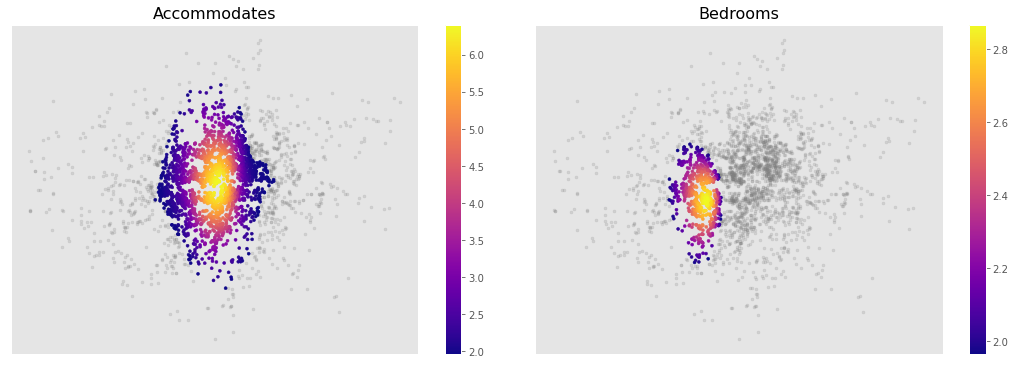

In [64]:
f,ax= plt.subplots(1,2,figsize=(15,5),subplot_kw=dict(aspect='equal'))
ax = ax.flatten()

for i,row in enumerate(filtered_estimates.T):
    if i <2:
        listings_tmp =gdf2.assign(toplot = filtered_estimates.T[i+1])
        listings_tmp.query('toplot == 0')\
                .sort_values('toplot')\
                .plot(color='grey',marker='.',ax=ax[i],alpha=.2)
        listings_tmp.query('toplot != 0')\
                .sort_values('toplot')\
                .plot('toplot',cmap='plasma',marker='.',ax=ax[i],legend=True)
        ax[i].set_title(['Accommodates','Bedrooms'] [i], fontsize=16)
    
        ax[i].set_xticklabels([]) 
        ax [i] .set_yticklabels([]) 
        ax [i] .set_xticks([]) 
        ax [i] .set_yticks([])
    else:
        break
f.tight_layout()

plt.show()

In [65]:
f.savefig('GWR2-addtion.jpg', dpi=300)

___

## Executive Briefing

Airbnb has been engaged in short-term rental services (_STR_) since it was founded in 2008. In essence, it has never owned its own investment real estate to a large extent, but it is gradually eroding the market share of traditional accommodation industries, such as the hotel and leasing industry(Horn and Merante, 2017). 

### Airbnb, an emerging investment method

__Compared with traditional house leasing, Airbnb provides a more risk-tolerant rental method.__ As far as the short-term leasing industry is concerned, the lessee’s credit level and financial status are the most important rental indicators for house owners (Sanderson, 2016). But Airbnb offers a "put eggs in different baskets" rental option, which means that the head of the household can get income from multiple tenants. Even if any of these orders are at risk, that is only a small part of the total income of the host.

__Investing in Airbnb rentals will effectively increase the passive income of individuals.__ After the 2008 financial crisis, house leasing has become a new financial asset (Fields, 2019). Airbnb leverages its own advantages as a network service company to have greater flexibility in the STR market. 

>According to data from Inside Airbnb, the average daily rent in London is $120, which is obviously more attractive than the average monthly average of £1,556 for traditional long-term rentals (Statista Research Department, 2020). 

In the study of Aablers and others (2014), it suggested that Airbnb can be used as a tool for the financialization of rental housing, which means that Airbnb will take part of the risk of housing investment and may profit from it.

### A guidance of Airbnb's investment in London

In this part, we conducted two regression analyses through the collected Airbnb open data (_from Inside Airbnb website_) and point of interest data (_POI, from OpenStreetMap website_) to perform a fitting analysis on the spatial external environment of the Airbnb distribution and the internal choices of users.

#### The location choice of Airbnb in London

First, let us have a global understanding of the spatial distribution of Airbnb in London. Through the Kernel Density Estimation (_KDE_) map of Airbnb in geographic space, it can be found that __there are currently three Airbnb clusters in London, mainly located on the north side of the Thames. In addition, there is a gestational cluster in the southern area.__ This situation also occurs in Sydney, where Airbnb’s clusters extend to the core of the city, and Sydney has been affected by tight rental demand (Gurran and Phibbs, 2017). This has greatly increased the rent pressure in the region, leading to a large number of homogeneous competitions in these regions.

<img src="https://github.com/HaochengSun722/i2p_data/blob/main/KDE.jpg?raw=true" alt="KDE map of Airbnb" width="800" />

In the next step, we will focus on the LSOA(_Lower Layer Super Output Areas_) level. In the OLS model, the number of Airbnb in each LSOA is used as the dependent variable, and the statistics of each type of POI in the LSOA are used as the independent variable. The purpose of this analysis is to __try to avoid the location of investment in areas with serious homogeneity competition, that is, locations with high Airbnb numbers.__ In addition, identify potential investment locations based on the distribution of POI in each LSOA. The fitted R square value of the OLS model is 0.45.

<img src="https://github.com/HaochengSun722/i2p_data/blob/main/poi%20distribution1.jpg?raw=true" alt="poi distribution1" width="800" />

By observing the distribution of POI in London, we find the following interesting phenomena:

1. __The distribution pattern of the number of Airbnb on LSOA overlaps with the distribution of tourist attractions.__ We are not surprised to find that the number of Airbnb in the city centre adjacent to the attraction has increased significantly. In addition, although attractions in other areas are limited, Airbnb also benefits from tourist demand, such as Heathrow Airport, southeast of Bromley, northwest of Hillingdon and East Enfield. This is in line with the findings of Eugenio-Martin et al.(2019) in Canary Islands.

<img src="https://github.com/HaochengSun722/i2p_data/blob/main/poi%20distribution2.jpg?raw=true" alt="poi distribution2" width="800" />

2. __Daily use spaces such as parks and public transportation show the difference between the centre and the periphery.__ Daily space is highly correlated with the number of Airbnb in the central area, but has no correlation in the periphery. This may be due to the fact that the development intensity of the central area is much higher than that of the periphery, and limited public resources have been invaded. This explains the bad impact of Airbnb on the community (Stergiou and Farmaki, 2020). Short-term rentals in residential areas will increase the length of stay, thereby increasing the possibility of affecting neighbours (such as destructive behaviour, noise).


<img src="https://github.com/HaochengSun722/i2p_data/blob/main/poi%20distribution3.jpg?raw=true" alt="poi distribution3" width="800" />

After preliminary analysis and evaluation of spatial distribution, we can preliminarily judge that __the potential cluster on the south bank of the Thames are likely to be the current locations with more investment prospects.__ There are a lot of historical attractions here, daily activity space (parks, public transportation, etc.) is at a medium level, and it has a good Airbnb rental basis.

#### The business model under the urban space

After completing the site selection analysis, we need to simulate and analyze the content that Airbnb needs to invest in. Since it is recognized that Airbnb has strong autocorrelation in space, we will use the GWR model to simulate the relationship between Airbnb housing elements and house prices. Use this as a guide for investors to __focus on specific housing elements for a specific space in London.__

<img src="https://github.com/HaochengSun722/i2p_data/blob/main/GWR2-addtion.jpg?raw=true" alt="GWR" width="800" />

The grey point in the figure represents that its significance is estimated as unimportant, and the other coloured points have statistical significance.According to the results, __in the central area of London, we need to pay more attention to the housing capacity. In the south side of the Thames, we need to pay more attention to the number of bedrooms.__ This difference is explained in Voltes-Dorta 's (2020)research. It stated that the reason for this difference was the difference in location and type of house. In the downtown apartment, the extra bedroom is obviously more valuable, but the house is different. This is similar to the traditional rental industry.

### Information that investors need to pay attention

Since its launch in 2008, Airbnb has become a major player in the tourism industry, while the City of London has become the second largest market (_in 2016, the number of Airbnb hosts in London reached 47,000_). However, many studies have shown that Airbnb’s rents are difficult to be restricted by traditional laws and regulations(Fields, 2019). The vicious competition of rents will force housing prices to continue to rise and the community environment deteriorates. In January 2017, Airbnb introduced a 90-day limit on 'entire home' listings in the Greater London area now commonly known as the __'90-Day Airbnb Rule'.__

Although half of the people who support or oppose the plan stand, Wells (2019) analyses the plan from an objective perspective. He analysed the impact of Airbnb short-term rentals on the city in the form of spill-over effects. He pointed out that __the spill-over effect will reduce the living convenience of real estate near the real estate that is the object of short-term rental.__

This leads to the most important point that needs to be paid attention to when investing in Airbnb, __how to regulate rental behaviour at the community level and reduce the impact on community safety, environment, economy, culture, etc.__ (Stergiou and Farmaki, 2020). Only in this way can it be done:

>"to help ensure that home sharing grows responsibly and sustainably, and makes London's communities stronger". said by Airbnb.


___

## Reference

Aalbers, MB, Christophers, B (2014) Centring housing in political economy. Housing, Theory and Society 31(4): 373–394.

Fields, D (2019) Automated landlord: Digital technologies and post-crisis financial accumulation. Environment and Planning A: Economy and Space. Epub ahead of print 1 May 2019. DOI: 10.1177/0308518X19846514.

Eugenio-Martin, J. L., Cazorla-Artiles, J. M. and González-Martel, C. (2019). ‘On the determinants of Airbnb location and its spatial distribution’. Tourism Economics. SAGE Publications Inc., 25 (8), pp. 1224–1244. doi: 10.1177/1354816618825415.

Gurran, N. and Phibbs, P. (2017). ‘When Tourists Move In: How Should Urban Planners Respond to Airbnb?’ Journal of the American Planning Association. Routledge, 83 (1), pp. 80–92. doi: 10.1080/01944363.2016.1249011.

Horn, K. and Merante, M. (2017). ‘Is home sharing driving up rents? Evidence from Airbnb in Boston’. Journal of Housing Economics. Academic Press Inc., 38, pp. 14–24. doi: 10.1016/j.jhe.2017.08.002.

Stergiou, D. P. and Farmaki, A. (2020). ‘Resident perceptions of the impacts of P2P accommodation: Implications for neighbourhoods’. International Journal of Hospitality Management. Elsevier Ltd, 91, p. 102411. doi: 10.1016/j.ijhm.2019.102411.

Voltes-Dorta, A. and Inchausti-Sintes, F. (2020). ‘The spatial and quality dimensions of Airbnb markets’. Tourism Economics. SAGE Publications Inc., p. 135481661989807. doi: 10.1177/1354816619898075.

Wells, L. (2019). ‘Planning for problems with short-term lets? A comparative economic analysis of the use of town planning versus private law systems to tackle spill-over effects’. in European Journal of Risk Regulation. Cambridge University Press, pp. 60–79. doi: 10.1017/err.2019.21.

Sanderson, D. C. and Edwards, V. M. (2016) Determinants of satisfaction amongst tenants of UK Offices. Journal of Corporate Real Estate, 18 (2). pp. 102­131. ISSN 1463­001X doi: https://doi.org/10.1108/JCRE­09­2015­0022 Available at http://centaur.reading.ac.uk/51460/
